# Simple pendulum system

Consider a simple pendulum of length $l$ and mass $m$ concentrated at its bob. The pivot of the pendulum is attached to a fix point. The system is submitted to a uniform, constant gravitational acceleration field $g$ and moves without friction.

The generalised coordinate of the system is the angle $\theta$ of the pendulum with the downward vertical direction. The standard (Cartesian) coordinates of the bob are then given by

\begin{equation*}
x = l\sin\theta
\hspace{2cm}
y = -l\cos\theta
\end{equation*}

The only active force is weight with coordinates $(0,-mg)$, hence of the form $-\nabla V$ with $V=mgy=-mgl\cos\theta$. Hence the Lagrangian

\begin{eqnarray*}
\mathcal{L} & = & ml(\frac{1}{2}l\dot{\theta}^2+g\cos\theta)
\end{eqnarray*}

The equations of the dynamics are given by:

\begin{equation*}
\begin{array}{rrcl}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1cm} &
l\ddot{\theta} & = & -g\sin\theta
\end{array}
\end{equation*}

Documentation: [here](../doc/_build/html/odesimu.html)

In [1]:
%pylab notebook
# for external animation (less resource consuming), use appropriate backend, e.g. qt5

import logging
from functools import partial
from scipy.integrate import quad
from ipyshow.util import Setup
from ipyshow.odesimu import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


## Pendulum class

In [2]:
#----------------------------------------------------------------------------------------------------
class Pendulum (System):
#----------------------------------------------------------------------------------------------------

  shadowshape = (2,)

  @Setup(
    'L: length of the pendulum [m]',
    'G: intensity of the gravitation [m.sec^-2]',
  )
  def __init__(self,L,G):
    self.L, self.G = L, G
    def main(t,state,a=-G/L):
      θ,θʹ = state
      θʺ = a*sin(θ)
      return array((θʹ,θʺ))
    self.main = main
    def jac(t,state,a=-G/L):
      θ,θʹ = state
      return array(((0,1),(a*cos(θ),0)))
    self.jacobian = jac
    def fordisplay(state):
      θ,θʹ = state
      live = L*array((sin(θ),-cos(θ)))
      return live, live
    self.fordisplay = fordisplay

  def display(self,ax,ini=None,refsize=None,**ka):
    L = 1.05*self.L
    ax.set_xlim(-L,L)
    ax.set_ylim(-L,L)
    ax.scatter((0.,),(0.,),c='k',marker='o',s=refsize)
    diag_l, = ax.plot((),(),'k')
    diag_s = ax.scatter((),(),s=refsize,marker='o',c='r')
    tail_l, = ax.plot((),(),'y')
    a = -self.G/self.L
    E = self.analytics(ini)
    c = .5*E/a
    if c<-1: k = 1; α = pi
    elif c==-1: k = nan; α = pi
    else: k = 2; α = arccos(c)
    if α<.1: T = pi/sqrt(2)
    else: T, err = quad((lambda θ,c=c: 1/sqrt(cos(θ)-c)),0,α)
    T *= k*sqrt(-2/a)
    ax.set_title(r'trajectory:CircularSegment($R$={:.2f},$\alpha$={:.2f}) period:{:.2f}'.format(self.L,degrees(α),T))
    def disp(t,live,tail):
      x,y = live
      diag_l.set_data((0,x),(0,y))
      diag_s.set_offsets(((x,y),))
      tail_l.set_data(tail[:,0],tail[:,1])
    return super().display(ax,disp,ini=ini,**ka)

  def analytics(self,ini):
    θ,θʹ = ini
    return square(θʹ)-2*self.G/self.L*cos(θ)

  @staticmethod
  @Setup(
    'θ: angle [deg]',
    'θʹ: angular speed [deg.sec^-1]',
    θʹ=0.
  )
  def makestate(θ,θʹ): return radians((θ,θʹ))

  @Setup(
    System.launch,
    'refsize: average size (area) of the bob for display [pt^2]',
    taild=1.,refsize=50.,hooks=(partial(logger_hook,logger=logging.getLogger()),)
  )
  def launch(self,*a,**ka): return super().launch(*a,**ka)

In [3]:
Setup.display(Pendulum)

**** Pendulum.__init__(self, L, G) ****
    L         : length of the pendulum [m]
    G         : intensity of the gravitation [m.sec^-2]
**** Pendulum.launch(self, *a, **ka) ****
    maxtime   (inf       ): total simulation time length [sec]
    srate     (25.0      ): sampling rate [sec^-1]
    taild     (1.0       ): shadow duration [sec]
    hooks     ((functools): tuple of display hooks []
    ini       : initial state []
    refsize   (50.0      ): average size (area) of the bob for display [pt^2]
**** Pendulum.makestate(θ, θʹ) ****
    θ         : angle [deg]
    θʹ        (0.0       ): angular speed [deg.sec^-1]

<IPython.core.display.Javascript object>


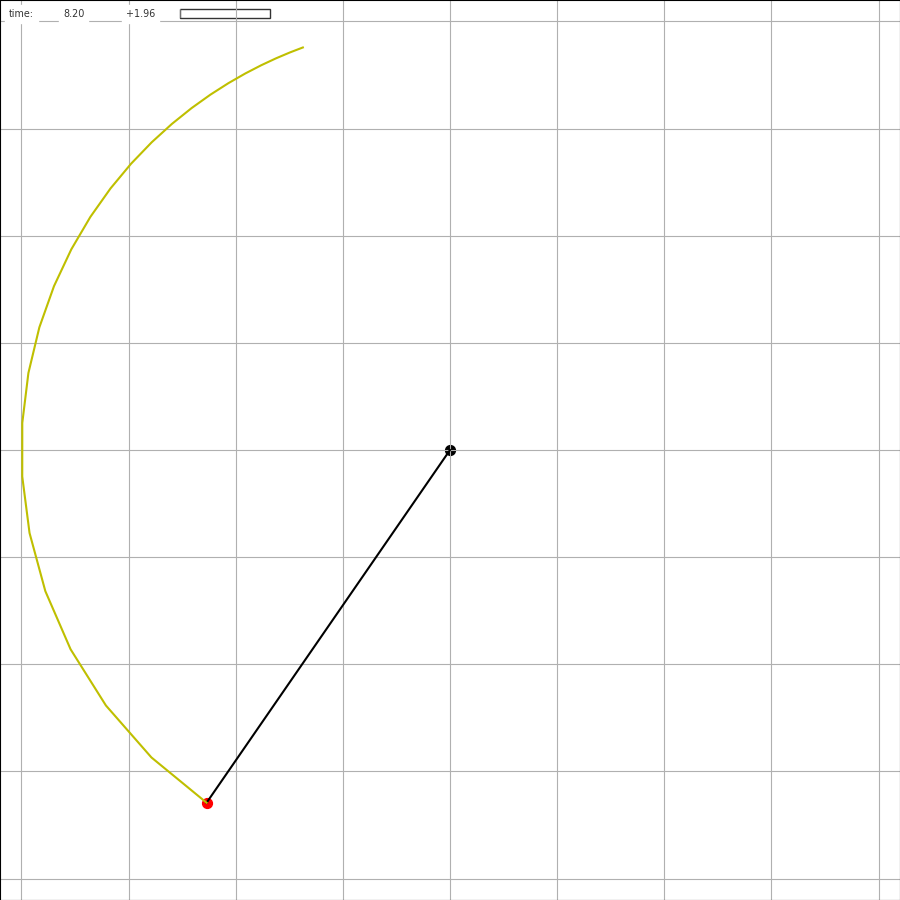

In [4]:
logging.basicConfig(level='WARN') # can be changed dynamically by logger_hook
syst = Pendulum(L=2.,G=9.81,)
ini = dict(θ=179.)
syst.launch(ini=syst.makestate(**ini))

Trajectory
----------

The law of conservation of energy yields $\dot{\theta}^2=\frac{2g}{l}(\cos\theta-c)$ for some constant $c$, computed from the total energy $E=-\frac{2mgc}{l}$. The initial condition defines the value of $c$. By construction, it is impossible that $c\gt1$.

* If $c\lt-1$ then the trajectory is the whole circle ($\alpha=\pi$) and the motion is periodic;

* if $c=-1$ the trajectory is a circle segment ending at the top-most point of the circle, toward which the bob converges (but which it never reaches);

* if $-1\lt c\lt1$ the trajectory is a circle segment limited by the angles $-\alpha$ and $\alpha$ where $\cos\alpha=c$ and the motion is periodic;

* if $c=1$, the trajectory is the bottom-most point of the circle and the motion is null;

Periodicity
-----------

When $|c|\not=1$, the motion is periodic and the period is given by

\begin{equation*}
T = k\sqrt{\frac{2l}{g}}\int_0^\alpha\frac{\mathbf{d}\theta}{\sqrt{\cos\theta-c}}
\textrm{ where } k=1 \textrm{ if } c\lt-1 \textrm{ and } k=2 \textrm{ if } -1\lt c\lt 1
\end{equation*}

Now, when $-1<c<1$, we have $k=2$ and $c=\cos\alpha$ with $0<\alpha<\pi$. Using the change of variable $t=\frac{\theta}{\alpha}$ we get

\begin{equation*}
T=2\sqrt{\frac{2l}{g}}I(\alpha)
\hspace{1cm}\textrm{where}\hspace{1cm}
I(\alpha)\triangleq\int_0^\alpha\frac{\mathbf{d}\theta}{\sqrt{\cos\theta-\cos\alpha}}=
\int_0^1\frac{\alpha\mathbf{d}t}{\sqrt{\cos t\alpha-\cos\alpha}}
\end{equation*}

When $t\downarrow1$, we have $\cos t\alpha-\cos\alpha\sim(1-t)\alpha\sin\alpha$ and since $\int_0^1\frac{\mathbf{d}t}{\sqrt{1-t}}$ is finite, so is $I(\alpha)$. Furthermore, the integrand is monotone increasing in $\alpha$, hence so is $I(\alpha)$.

* When $\alpha$ tends to $0$, the integrand converges pointwise to $\sqrt{\frac{2}{1-t^2}}$. By the [dominated convergence theorem](http://en.wikipedia.org/wiki/Dominated_convergence_theorem), and using the change of variable $t=\sin u$, we have
\begin{equation*}
\lim_{\alpha\downarrow0}I(\alpha) = \int_0^1\frac{\sqrt{2}\mathbf{d}t}{\sqrt{1-t^2}} =
\int_0^{\frac{\pi}{2}}\frac{\sqrt{2}\cos u\mathbf{d}u}{\sqrt{1-\sin^2u}} = \frac{\pi}{\sqrt{2}}
\hspace{1cm}\textrm{hence}\hspace{1cm}
\lim_{c\downarrow1}T = 2\pi\sqrt{\frac{l}{g}}
\end{equation*}

* When $\alpha$ tends to $\pi$, the integrand converges pointwise to $\frac{\pi}{\sqrt{2}\cos(\frac{\pi}{2}t)}$. By the [monotone convergence theorem](http://en.wikipedia.org/wiki/Monotone_convergence_theorem), and using the change of variable $t=1-\frac{2u}{\pi}$, we have
\begin{equation*}
\lim_{\alpha\downarrow\pi}I(\alpha) = \int_0^1\frac{\pi\mathbf{d}t}{\sqrt{2}\cos(\frac{\pi}{2}t)} =
\sqrt{2}\int_0^{\frac{\pi}{2}}\frac{\mathbf{d}u}{\sin u} = \infty
\hspace{1cm}\textrm{hence}\hspace{1cm}
\lim_{c\downarrow-1}T = \infty
\end{equation*}